In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from datetime import datetime
#from prophet import Prophet

pd.options.display.max_columns = None

## Window Generator

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [3]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [4]:
def plot(self, model=None, plot_col='CONTEO', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [5]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [6]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Carga de los datos

In [7]:
dataVelocidadComplete = pd.read_csv('/content/drive/MyDrive/Maestría/Datos/Simplified/complete_data_2020.csv')
dataVelocidadComplete=dataVelocidadComplete.drop(columns=['Unnamed: 0'])
dataVelocidadComplete =dataVelocidadComplete.drop_duplicates()
dataVelocidadComplete.head()


,INICIO_FRANJA,AÑO,VEL_PROMEDIO,VEL_PONDERADA,VEL_MEDIA_PONDERADA,DIA,MES,FRANJA,INICIO,CONTROL,SHAPE.LEN
0,2020-01-01 00:00:00,2020.0,35.999663,35.209814,35.209814,1.0,1.0,MADRUGADA,NaN,NaN,NaN
1,2020-01-01 06:00:00,2020.0,31.052914,31.052914,31.052914,1.0,1.0,MAÑANA,NaN,NaN,NaN
2,2020-01-01 12:00:00,2020.0,30.161591,30.161591,30.161591,1.0,1.0,TARDE,NaN,NaN,NaN
3,2020-01-01 18:00:00,2020.0,30.673586,30.125589,30.125589,1.0,1.0,NOCHE,NaN,NaN,NaN
4,2020-01-02 00:00:00,2020.0,35.698508,35.698508,35.698508,2.0,1.0,MADRUGADA,NaN,NaN,NaN


In [8]:
dataVelocidadComplete['INICIO_FRANJA'] = pd.to_datetime(dataVelocidadComplete['INICIO_FRANJA'])

dataVelocidadComplete.index=dataVelocidadComplete['INICIO_FRANJA']

dataVelocidadComplete=dataVelocidadComplete.sort_index()
dataVelocidadComplete.head()
dataVelocidadComplete =dataVelocidadComplete.drop(columns=['INICIO','CONTROL','SHAPE.LEN','VEL_PONDERADA','VEL_MEDIA_PONDERADA','INICIO_FRANJA'])
dataVelocidadComplete['AÑO']=2020


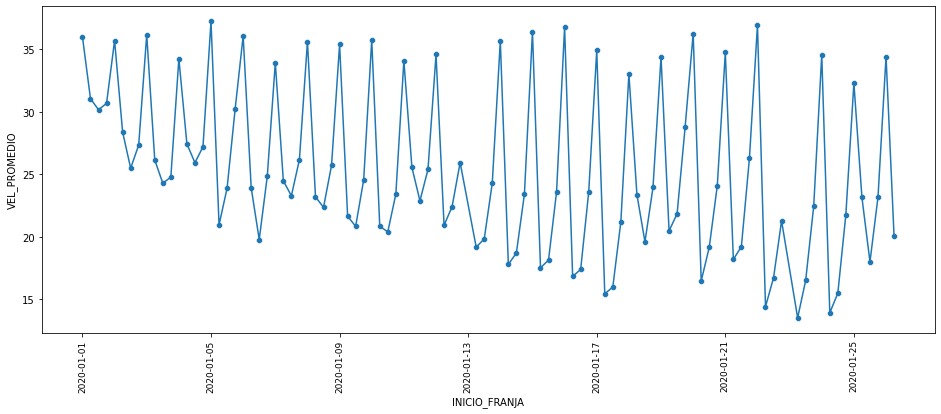

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
dataVelocidadComplete = dataVelocidadComplete.sort_index()
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=dataVelocidadComplete[0:100].index,y=dataVelocidadComplete[0:100].VEL_PROMEDIO)
sns.lineplot(x=dataVelocidadComplete[0:100].index,y=dataVelocidadComplete[0:100].VEL_PROMEDIO)

## Detección de anomalias

No handles with labels found to put in legend.


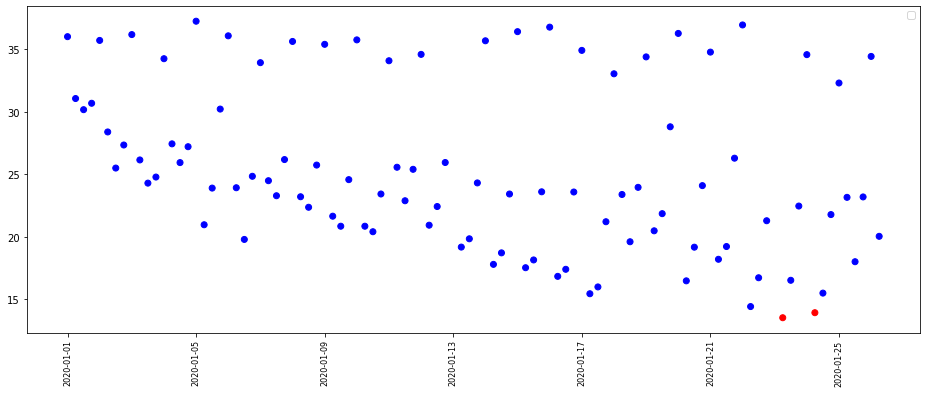

In [10]:
import matplotlib as pl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
seriesVelocidad = dataVelocidadComplete
outliers_fraction = 0.02
dataVelocidad = seriesVelocidad[['VEL_PROMEDIO']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataVelocidad)
dataScaledVelocidad = pd.DataFrame(dataVelocidad)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(dataScaledVelocidad)
anomalyResultsVelocidad = pd.Series(model.predict(dataScaledVelocidad))
# visualization
fig, ax = pl.pyplot.subplots(figsize=(16,6))
seriesVelocidad['anomaly2']=np.zeros(len(seriesVelocidad))
plt.xticks(rotation=90, fontsize=8)
for i in range (0,len(anomalyResultsVelocidad)):
  seriesVelocidad.loc[seriesVelocidad.index[i],'anomaly2']= anomalyResultsVelocidad[i]
colors = {1:'blue', -1:'red'}
ax.scatter(seriesVelocidad[:100].index, seriesVelocidad[:100]['VEL_PROMEDIO'], c=seriesVelocidad[:100]["anomaly2"].apply(lambda x: colors[x]))

pl.pyplot.legend()
pl.pyplot.show();
DataUsingIsolationForestVelocidad = seriesVelocidad.copy()

In [11]:
dataVelocidadComplete['AÑO']=dataVelocidadComplete['AÑO'].fillna(2020)
dataVelocidadComplete=dataVelocidadComplete.drop_duplicates()
for i in dataVelocidadComplete.index:
  if dataVelocidadComplete.loc[i,'anomaly2'].any()==-1:
    dataVelocidadComplete.loc[i,'VEL_PROMEDIO']= dataVelocidadComplete['VEL_PROMEDIO'].mean()


No handles with labels found to put in legend.


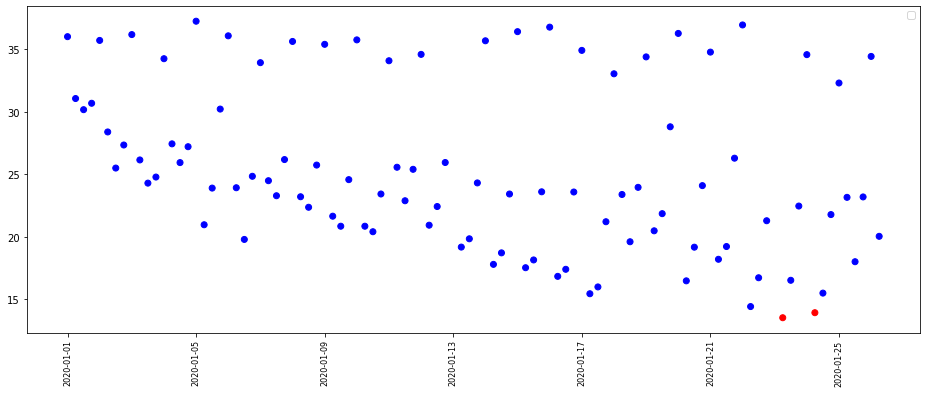

In [12]:
fig, ax = pl.pyplot.subplots(figsize=(16,6))
plt.xticks(rotation=90, fontsize=8)
colors = {1:'blue', -1:'red'}
ax.scatter(dataVelocidadComplete[:100].index, dataVelocidadComplete[:100]['VEL_PROMEDIO'], c=dataVelocidadComplete[:100]["anomaly2"].apply(lambda x: colors[x]))

pl.pyplot.legend()
pl.pyplot.show();

## Redes neuronales

In [13]:
dataVelocidadComplete =dataVelocidadComplete.sort_index()
dataVelocidadComplete=dataVelocidadComplete.drop(columns=['AÑO','DIA','MES','FRANJA','anomaly2'])

In [14]:
n = dataVelocidadComplete.shape[0]
num_features = dataVelocidadComplete.shape[1]
train_df = dataVelocidadComplete[0:int(n*0.7)]
val_df = dataVelocidadComplete[int(n*0.7):int(n*0.9)]
test_df = dataVelocidadComplete[int(n*0.9):]
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.head()

,VEL_PROMEDIO
INICIO_FRANJA,
2020-01-01 00:00:00,1.347096
2020-01-01 06:00:00,0.600959
2020-01-01 12:00:00,0.466517
2020-01-01 18:00:00,0.543743
2020-01-02 00:00:00,1.301672


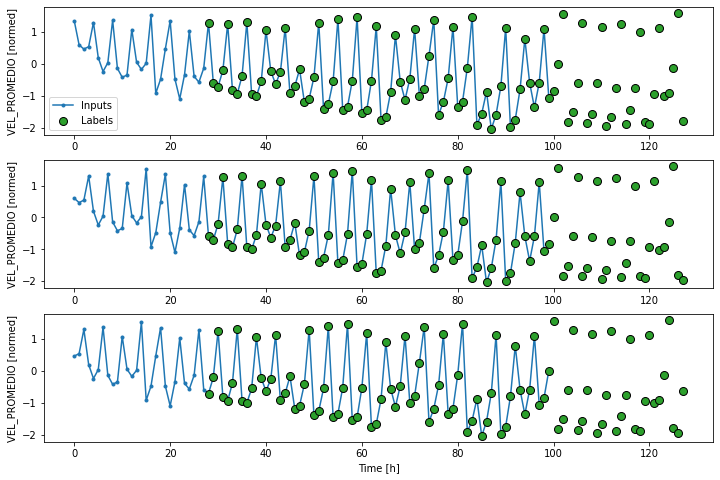

In [15]:
#MODELO DE VENTANA AMPLIA
val_performance = {}
performance = {}
INPUT_STEPS =100
OUT_STEPS =100
SHIFT =28 # 1 semana
wide_window = WindowGenerator(train_df=train_df,val_df=val_df,test_df=test_df,
    input_width=INPUT_STEPS, label_width=OUT_STEPS, shift=SHIFT,
    label_columns=['VEL_PROMEDIO'])

wide_window.plot(plot_col='VEL_PROMEDIO')

In [16]:
print(wide_window.train)
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

<MapDataset shapes: ((None, 100, 1), (None, 100, 1)), types: (tf.float32, tf.float32)>
Inputs shape (batch, time, features): (32, 100, 1)
Labels shape (batch, time, features): (32, 100, 1)


In [17]:
MAX_EPOCHS = 200

def compile_and_fit_speed(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, use_multiprocessing=True)
  return history

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 100, 1024)         2105344   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 100, 512)          2623488   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 100, 256)          656384    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)               

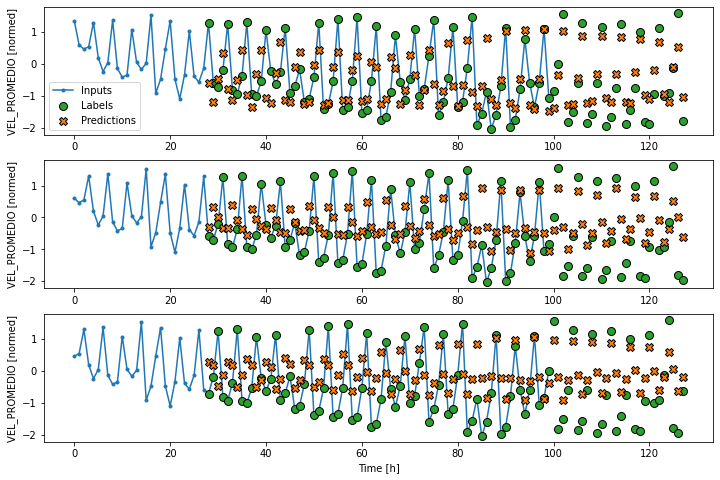

In [18]:
import tensorflow_datasets as tfds
import tensorflow as tf
def buildModel(retrain,route):
  if retrain:
    multi_lstm_model = tf.keras.Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(OUT_STEPS*num_features),
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    history = compile_and_fit_speed(multi_lstm_model, wide_window)
    print(history)
    multi_lstm_model.save(route)
    return multi_lstm_model
  else:
    multi_lstm_model = tf.keras.models.load_model(route)
    return multi_lstm_model

ROUTE = '/content/drive/MyDrive/Maestría/LSTMVelocidad.h5'
RETRAIN =False
multi_lstm_model = buildModel(RETRAIN,ROUTE)
wide_window.plot(multi_lstm_model,plot_col='VEL_PROMEDIO')
print(multi_lstm_model.summary())

In [19]:
SeriesToPredict = dataVelocidadComplete[:101]
ds_pred = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=SeriesToPredict,
      targets=None,
      sequence_length=OUT_STEPS,
      sequence_stride=OUT_STEPS,
      shuffle=False,
      batch_size=1,)
prediction = multi_lstm_model.predict(ds_pred)

In [20]:
last_pred =prediction[0][-29:-1]
fixed_pred = []
for pred in last_pred:
  fixed_pred.append((pred[0] * train_std["VEL_PROMEDIO"]) +train_mean["VEL_PROMEDIO"])
print(fixed_pred)

[33.9953025363052, 25.091525391030505, 22.956284214154508, 25.68983376530864, 33.43282961750763, 24.85367534377991, 23.592507612134444, 25.841035762356125, 33.11410659461491, 24.7944290873039, 23.911385145464127, 26.0375335214336, 32.534618164551176, 25.557458430320658, 23.93605564120489, 25.554916615082455, 31.743529074156324, 25.762090413086096, 23.803109882135697, 25.555006515656387, 31.43638247901487, 25.62456901117915, 24.122328049727937, 25.90263771024474, 30.67172218152, 25.992500644488487, 24.146592115841045, 26.108391869514932]


In [21]:
predictions_regression = [35.26265275,28.81652707,28.70021403,29.68754191,35.96940885,27.54934296
,26.15385702,27.56569788,35.95624503,26.09913625,24.46349924,25.82497361
,34.98289978,26.49333908,25.19643039,26.26445692,36.2665854,23.2151179
,24.55239975,28.15583183,36.10438897,23.51169584,21.27520153,25.78996595
,34.84818787,24.15651994,22.4086682,25.80672976]
len(predictions_regression)

28

28 28


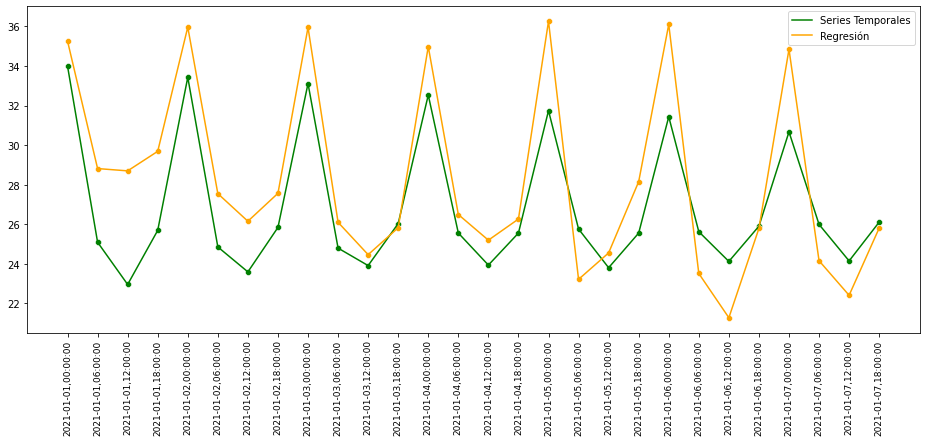

In [22]:
print(len(dataVelocidadComplete.index[-28:]),len(fixed_pred))
label_dates = ['2021-01-01,00:00:00','2021-01-01,06:00:00'
,'2021-01-01,12:00:00','2021-01-01,18:00:00'
,'2021-01-02,00:00:00','2021-01-02,06:00:00'
,'2021-01-02,12:00:00','2021-01-02,18:00:00'
,'2021-01-03,00:00:00','2021-01-03,06:00:00'
,'2021-01-03,12:00:00','2021-01-03,18:00:00'
,'2021-01-04,00:00:00','2021-01-04,06:00:00'
,'2021-01-04,12:00:00','2021-01-04,18:00:00'
,'2021-01-05,00:00:00','2021-01-05,06:00:00'
,'2021-01-05,12:00:00','2021-01-05,18:00:00'
,'2021-01-06,00:00:00','2021-01-06,06:00:00'
,'2021-01-06,12:00:00','2021-01-06,18:00:00'
,'2021-01-07,00:00:00','2021-01-07,06:00:00'
,'2021-01-07,12:00:00','2021-01-07,18:00:00']
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=label_dates,y=fixed_pred,color='green',legend='auto')
sns.lineplot(x=label_dates,y=fixed_pred,color='green',label='Series Temporales')
sns.scatterplot(x=label_dates,y=predictions_regression,color='orange',legend='auto')
sns.lineplot(x=label_dates,y=predictions_regression,color='orange',label='Regresión')
plt.legend()
plt.show()

In [23]:
dataVelocidadComplete.index[-150:]

DatetimeIndex(['2020-11-19 00:00:00', '2020-11-19 06:00:00',
               '2020-11-19 12:00:00', '2020-11-19 18:00:00',
               '2020-11-20 00:00:00', '2020-11-20 06:00:00',
               '2020-11-20 12:00:00', '2020-11-20 18:00:00',
               '2020-11-21 00:00:00', '2020-11-21 06:00:00',
               ...
               '2020-12-28 12:00:00', '2020-12-28 18:00:00',
               '2020-12-29 00:00:00', '2020-12-29 06:00:00',
               '2020-12-29 12:00:00', '2020-12-29 18:00:00',
               '2020-12-30 00:00:00', '2020-12-30 06:00:00',
               '2020-12-30 12:00:00', '2020-12-30 18:00:00'],
              dtype='datetime64[ns]', name='INICIO_FRANJA', length=150, freq=None)

In [24]:
dataComparisson = pd.read_csv('/content/drive/MyDrive/Maestría/Datos/Simplified/2021-1.csv')
dataComparisson.index = dataComparisson['INICIO_FRANJA']
dataComparisson = dataComparisson.sort_index()
dataComparisson.shape

(118, 9)

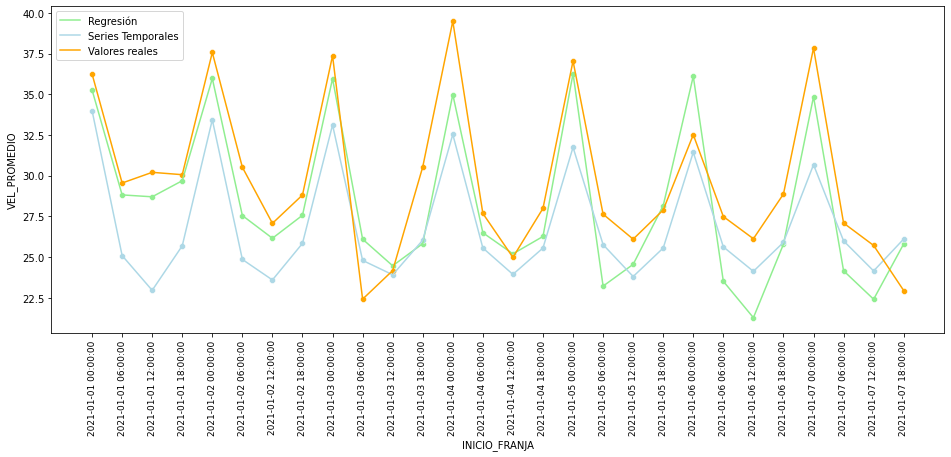

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=dataComparisson.index[0:28],y=predictions_regression,color='lightgreen',legend='auto')
sns.lineplot(x=dataComparisson.index[0:28],y=predictions_regression,color='lightgreen',legend='auto',label="Regresión")
sns.scatterplot(x=dataComparisson.index[0:28],y=fixed_pred,color='lightblue',legend='auto')
sns.lineplot(x=dataComparisson.index[0:28],y=fixed_pred,color='lightblue',legend='auto',label="Series Temporales")
sns.scatterplot(x=dataComparisson.index[0:28],y=dataComparisson['VEL_PROMEDIO'][0:28],color='orange',legend='auto')
sns.lineplot(x=dataComparisson.index[0:28],y=dataComparisson['VEL_PROMEDIO'][0:28],color='orange',legend='auto',label="Valores reales")

In [26]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Regression")
print('MAE:',mean_absolute_error(predictions_regression,dataComparisson['VEL_PROMEDIO'][0:28]))
print('MSE:',mean_squared_error(predictions_regression,dataComparisson['VEL_PROMEDIO'][0:28]))
print('RMSE:',np.sqrt(mean_squared_error(predictions_regression,dataComparisson['VEL_PROMEDIO'][0:28])))
print("Series")
print('MAE:',mean_absolute_error(fixed_pred,dataComparisson['VEL_PROMEDIO'][0:28]))
print('MSE:',mean_squared_error(fixed_pred,dataComparisson['VEL_PROMEDIO'][0:28]))
print('RMSE:',np.sqrt(mean_squared_error(fixed_pred,dataComparisson['VEL_PROMEDIO'][0:28])))

Regression
MAE: 2.23679896044981
MSE: 7.183200177036753
RMSE: 2.680149282602884
Series
MAE: 3.2573535181785016
MSE: 14.115043940951916
RMSE: 3.75699932671699
